In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/DL Lab/Lab6/code')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install Pillow
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2 MB 1.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.4 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
jax 0.3.8 requires scipy>=1.2.1, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
from datasets import *
from utils import *

### visualization without attention

In [3]:
# Hyperparameters
image_path = '/content/drive/MyDrive/Colab Notebooks/DL Lab/Lab6/data/coco2014/test2014/COCO_test2014_000000000069.jpg'
checkpoint = '/content/drive/MyDrive/Colab Notebooks/DL Lab/Lab6/code/saved_checkpoints/simple_rnn/BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar'
word_map_file = '/content/drive/MyDrive/Colab Notebooks/DL Lab/Lab6/data/coco2014/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json'
beam_size = 5
smooth = True
attention = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# Load model
checkpoint = torch.load(checkpoint, map_location=str(device))
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()

DecoderWithRNN(
  (embedding): Embedding(9490, 512)
  (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (init): Linear(in_features=401408, out_features=512, bias=True)
  (decode_step): LSTMCell(512, 512)
  (fc): Linear(in_features=512, out_features=9490, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [4]:
# Load word map (word2ix)
with open(word_map_file, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

In [6]:
# Read image and process
img = imread(image_path)
if len(img.shape) == 2:
    img = img[:, :, np.newaxis]
    img = np.concatenate([img, img, img], axis=2)
img = imresize(img, (256, 256))
img = img.transpose(2, 0, 1)
img = img / 255.
img = torch.FloatTensor(img).to(device)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([normalize])
image = transform(img)  # (3, 256, 256)
image = image.unsqueeze(0)  # (1, 3, 256, 256)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  


In [9]:
k = beam_size
vocab_size = len(word_map)

# Tensor to store top k previous words at each step; now they're just <start>
k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

# Tensor to store top k sequences; now they're just <start>
seqs = k_prev_words  # (k, 1)

# Tensor to store top k sequences' scores; now they're just 0
top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

# Encode
encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)

if attention:
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)
    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)
else:
    encoder_out = encoder_out.reshape(1, -1)
    encoder_dim = encoder_out.size(1)
    encoder_out = encoder_out.expand(k, encoder_dim)

# Lists to store completed sequences, their alphas and scores
complete_seqs = list()
complete_seqs_scores = list()
if attention:
    complete_seqs_alpha = list()


# Start decoding
step = 1
if attention:
    mean_encoder_out = encoder_out.mean(dim=1)
    h = decoder.init_h(mean_encoder_out)  # (1, decoder_dim)
    c = decoder.init_c(mean_encoder_out)
else:
    init_input = decoder.bn(decoder.init(encoder_out))
    h, c = decoder.decode_step(init_input)  # (batch_size_t, decoder_dim)

smoth_wrong = False

# s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
while True:

    embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)
    if attention:
        scores, alpha, h, c = decoder.one_step(embeddings, encoder_out, h, c)
        alpha = alpha.view(-1, enc_image_size, enc_image_size)
    else:
        scores, h, c = decoder.one_step(embeddings, h, c)
    scores = F.log_softmax(scores, dim=1)
    scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

    # For the first step, all k points will have the same scores (since same k previous words, h, c)
    if step == 1:
        top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
    else:
        # Unroll and find top scores, and their unrolled indices
        top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

    # Convert unrolled indices to actual indices of scores
    prev_word_inds = top_k_words // vocab_size  # (s)
    next_word_inds = top_k_words % vocab_size  # (s)

    # Add new words to sequences, alphas
    seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
    if attention:
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                                dim=1)  # (s, step+1, enc_image_size, enc_image_size)

    # Which sequences are incomplete (didn't reach <end>)?
    incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                       next_word != word_map['<end>']]
    complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

    # Set aside complete sequences
    if len(complete_inds) > 0:
        complete_seqs.extend(seqs[complete_inds].tolist())
        complete_seqs_scores.extend(top_k_scores[complete_inds])
        if attention:
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
        
    k -= len(complete_inds)  # reduce beam length accordingly

    # Proceed with incomplete sequences
    if k == 0:
        break
    seqs = seqs[incomplete_inds]
    if attention:
        seqs_alpha = seqs_alpha[incomplete_inds]
    h = h[prev_word_inds[incomplete_inds]]
    c = c[prev_word_inds[incomplete_inds]]
    encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
    top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
    k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

    # Break if things have been going on too long
    if step > 50:
        smoth_wrong = True
        break
    step += 1

if not smoth_wrong:
    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    if attention:
        alphas = complete_seqs_alpha[i]
        alphas = torch.FloatTensor(alphas)
else:
    seq = seqs[0][:20]
    if attention:
        alphas = complete_seqs_alpha[0]
        alphas = torch.FloatTensor(alphas)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


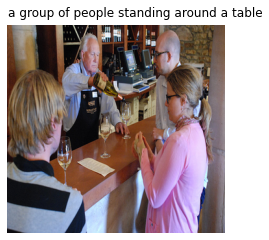

In [10]:
if attention:
    visualize_att(image_path, seq, alphas, rev_word_map, smooth)
else:
    visualize(image_path, seq, rev_word_map)

### visualization with attention

In [14]:
# Hyperparameters
image_path = '/content/drive/MyDrive/Colab Notebooks/DL Lab/Lab6/data/coco2014/test2014/COCO_test2014_000000000069.jpg'
checkpoint = '/content/drive/MyDrive/Colab Notebooks/DL Lab/Lab6/code/saved_checkpoints/attention/BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar'
word_map_file = '/content/drive/MyDrive/Colab Notebooks/DL Lab/Lab6/data/coco2014/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json'
beam_size = 5
smooth = True
attention = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
# Load model
checkpoint = torch.load(checkpoint, map_location=str(device))
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()

DecoderWithAttention(
  (attention): Attention(
    (f_att1): Linear(in_features=2048, out_features=512, bias=True)
    (f_att2): Linear(in_features=512, out_features=512, bias=True)
    (f_att3): Linear(in_features=512, out_features=1, bias=True)
  )
  (embedding): Embedding(9490, 512)
  (dropout): Dropout(p=0.5, inplace=False)
  (decode_step): LSTMCell(2560, 512)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
  (f_beta): Linear(in_features=512, out_features=2048, bias=True)
  (fc): Linear(in_features=512, out_features=9490, bias=True)
)

In [16]:
# Read image and process
img = imread(image_path)
if len(img.shape) == 2:
    img = img[:, :, np.newaxis]
    img = np.concatenate([img, img, img], axis=2)
img = imresize(img, (256, 256))
img = img.transpose(2, 0, 1)
img = img / 255.
img = torch.FloatTensor(img).to(device)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([normalize])
image = transform(img)  # (3, 256, 256)
image = image.unsqueeze(0)  # (1, 3, 256, 256)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  


In [17]:
k = beam_size
vocab_size = len(word_map)

# Tensor to store top k previous words at each step; now they're just <start>
k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

# Tensor to store top k sequences; now they're just <start>
seqs = k_prev_words  # (k, 1)

# Tensor to store top k sequences' scores; now they're just 0
top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

# Encode
encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)

if attention:
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)
    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)
else:
    encoder_out = encoder_out.reshape(1, -1)
    encoder_dim = encoder_out.size(1)
    encoder_out = encoder_out.expand(k, encoder_dim)

# Lists to store completed sequences, their alphas and scores
complete_seqs = list()
complete_seqs_scores = list()
if attention:
    complete_seqs_alpha = list()


# Start decoding
step = 1
if attention:
    mean_encoder_out = encoder_out.mean(dim=1)
    h = decoder.init_h(mean_encoder_out)  # (1, decoder_dim)
    c = decoder.init_c(mean_encoder_out)
else:
    init_input = decoder.bn(decoder.init(encoder_out))
    h, c = decoder.decode_step(init_input)  # (batch_size_t, decoder_dim)

smoth_wrong = False

# s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
while True:

    embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)
    if attention:
        scores, alpha, h, c = decoder.one_step(embeddings, encoder_out, h, c)
        alpha = alpha.view(-1, enc_image_size, enc_image_size)
    else:
        scores, h, c = decoder.one_step(embeddings, h, c)
    scores = F.log_softmax(scores, dim=1)
    scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

    # For the first step, all k points will have the same scores (since same k previous words, h, c)
    if step == 1:
        top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
    else:
        # Unroll and find top scores, and their unrolled indices
        top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

    # Convert unrolled indices to actual indices of scores
    prev_word_inds = top_k_words // vocab_size  # (s)
    next_word_inds = top_k_words % vocab_size  # (s)

    # Add new words to sequences, alphas
    seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
    if attention:
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                                dim=1)  # (s, step+1, enc_image_size, enc_image_size)

    # Which sequences are incomplete (didn't reach <end>)?
    incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                       next_word != word_map['<end>']]
    complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

    # Set aside complete sequences
    if len(complete_inds) > 0:
        complete_seqs.extend(seqs[complete_inds].tolist())
        complete_seqs_scores.extend(top_k_scores[complete_inds])
        if attention:
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
        
    k -= len(complete_inds)  # reduce beam length accordingly

    # Proceed with incomplete sequences
    if k == 0:
        break
    seqs = seqs[incomplete_inds]
    if attention:
        seqs_alpha = seqs_alpha[incomplete_inds]
    h = h[prev_word_inds[incomplete_inds]]
    c = c[prev_word_inds[incomplete_inds]]
    encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
    top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
    k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

    # Break if things have been going on too long
    if step > 50:
        smoth_wrong = True
        break
    step += 1

if not smoth_wrong:
    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    if attention:
        alphas = complete_seqs_alpha[i]
        alphas = torch.FloatTensor(alphas)
else:
    seq = seqs[0][:20]
    if attention:
        alphas = complete_seqs_alpha[0]
        alphas = torch.FloatTensor(alphas)

/content/drive/MyDrive/Colab Notebooks/DL Lab/Lab6/code/models.py:203: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = F.softmax(e)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


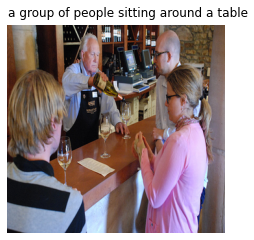

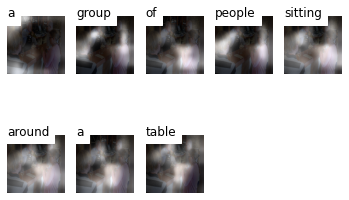

In [18]:
if attention:
    visualize_att(image_path, seq, alphas, rev_word_map, smooth)
else:
    visualize(image_path, seq, rev_word_map)